# KPI Calculation


#### Load data

In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

df_boston = pd.read_csv('./data/boston_2015.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_boston['end_station_id'].unique()
df_boston.drop(index=df_boston.loc[df_boston["end_station_id"] == "\\N"].index, inplace=True, axis=1)
df_boston = df_boston.astype({'end_station_id': np.int64})
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
df_boston['end_time'] = pd.to_datetime(df_boston['end_time'], format='%Y-%m-%d %X')

## Utilization
### Data preparation

In [192]:

df_splitted_trips = df_boston.copy()[:10000]
df_splitted_trips = df_splitted_trips[df_splitted_trips['end_time'].dt.hour - df_splitted_trips['start_time'].dt.hour > 2]

df_splitted_trips_overlapping_trips = df_splitted_trips.copy()
while not df_splitted_trips_overlapping_trips.empty:
    
    mask = (df_splitted_trips['start_time'].dt.hour != df_splitted_trips['end_time'].dt.hour)
    df_splitted_trips.loc[mask, 'times_tmp'] = df_splitted_trips[mask].start_time.apply(lambda x: [x.floor('H')+timedelta(hours=1)-timedelta(seconds=1), x.floor('H')+timedelta(hours=1)])
    df_splitted_trips=df_splitted_trips.explode('times_tmp', ignore_index=True)
    df_splitted_trips['times_tmp'] =  pd.to_datetime(df_splitted_trips['times_tmp'], format='%Y-%m-%d %H:%M:%S')
    df_splitted_trips['end_time'] = df_splitted_trips.apply(lambda x: x.times_tmp if x.times_tmp.minute == 59 else x.end_time, axis=1)
    df_splitted_trips['start_time'] = df_splitted_trips.apply(lambda x: x.times_tmp if x.times_tmp.minute == 0 else x.start_time, axis=1)
    df_splitted_trips['times_tmp'] = np.nan
    mask_new = (df_splitted_trips['start_time'].dt.hour != df_splitted_trips['end_time'].dt.hour)
    df_splitted_trips_overlapping_trips = df_splitted_trips[mask_new]
    print("Number overlap: " + str(len(df_splitted_trips[mask_new])))

df_splitted_trips


# For rides which happen in two hours (e.g. 8 and 9 am) we split them up into two rides
# Insert new 'end_time' (e.g. 08:59:59) and new 'start_time' (e.g. 09:00:00) in column 'times_tmp'
# !!! ONLY CORRECT IF WE ONLY HAVE TRIPS WITH TRIP LENGTH < 1h !!!
#df_splitted_trips['times_tmp'] = df_splitted_trips.apply((lambda x: [x.start_time.ceil('H')-timedelta(seconds=1), x.start_time.ceil('H')] if x.start_time.hour != x.end_time.hour else None), axis=1)

Number overlap: 51
Number overlap: 24
Number overlap: 19
Number overlap: 15
Number overlap: 15
Number overlap: 14
Number overlap: 14
Number overlap: 14
Number overlap: 13
Number overlap: 13
Number overlap: 12
Number overlap: 12
Number overlap: 10
Number overlap: 9
Number overlap: 9
Number overlap: 7
Number overlap: 6
Number overlap: 5
Number overlap: 5
Number overlap: 4
Number overlap: 2
Number overlap: 0


,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,times_tmp
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber,NaN
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber,NaN
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber,NaN
3,2015-01-01 00:53:46,2015-01-01 00:59:59,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,NaN
4,2015-01-01 01:00:00,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,NaN
...,...,...,...,...,...,...,...,...,...
11810,2015-02-20 12:00:00,2015-02-20 12:08:03,96,89,Cambridge Main Library at Broadway / Trowbridg...,Harvard Law School at Mass Ave / Jarvis St,1056,Customer,NaN
11811,2015-02-20 12:01:39,2015-02-20 12:03:09,72,72,One Broadway / Kendall Sq at Main St / 3rd St,One Broadway / Kendall Sq at Main St / 3rd St,718,Customer,NaN
11812,2015-02-20 12:03:17,2015-02-20 12:19:10,110,67,Harvard University Gund Hall at Quincy St / Ki...,MIT at Mass Ave / Amherst St,863,Subscriber,NaN
11813,2015-02-20 12:10:33,2015-02-20 12:20:08,80,76,MIT Stata Center at Vassar St / Main St,Central Sq Post Office / Cambridge City Hall a...,1097,Subscriber,NaN


In [10]:
# Create separate rows for every new end- and start-time
df_splitted_trips=df_splitted_trips.explode('times_tmp')
# If 'times_tmp' is an end_time (minute = 59), replace 'end_time'
df_splitted_trips['end_time'] = df_splitted_trips.apply(lambda x: x.times_tmp if x.times_tmp.minute == 59 else x.end_time, axis=1)
# If 'times_tmp' is a start_time (minute = 0), replace 'start_time'
df_splitted_trips['start_time'] = df_splitted_trips.apply(lambda x: x.times_tmp if x.times_tmp.minute == 0 else x.start_time, axis=1)

In [11]:
# Insert date into separate column
df_splitted_trips['Date'] = df_splitted_trips['start_time'].dt.date
# Insert time of day into separate column
df_splitted_trips['Time of day (hour)'] = df_splitted_trips['start_time'].dt.hour

### Utilization rate per day

In [12]:
amountOfBikes = len(df_splitted_trips['bike_id'].unique())

# Group all trips of the year by date and get number of unique values of attributes
df_utilization_rate_per_day = df_splitted_trips.groupby('Date').nunique()

# Calculate daily utilization rate: number of used bikes / total amount of bikes
df_utilization_rate_per_day['Utilization Rate'] = df_utilization_rate_per_day['bike_id']/amountOfBikes*100

# Plot Utilization Rate over year
sns.lineplot(data=df_utilization_rate_per_day, x='Date', y='Utilization Rate')

AttributeError: module 'numpy' has no attribute '_no_nep50_warning'

### Utilization rate per hour

<AxesSubplot: xlabel='Time of day (hour)', ylabel='Utilization rate in %'>

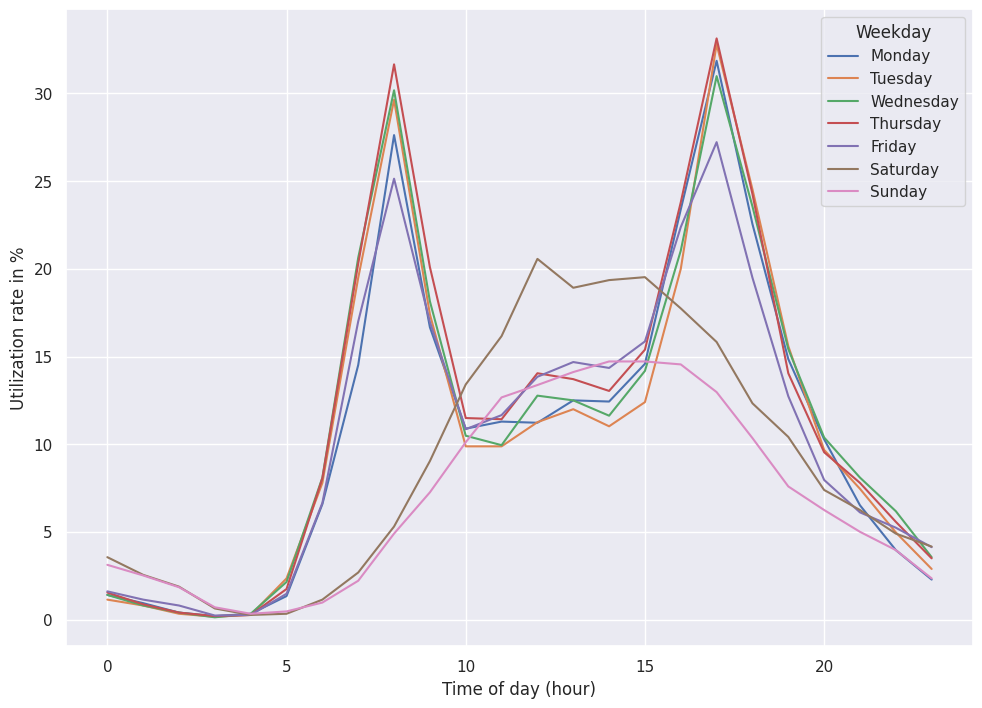

In [ ]:
# Utilization rate over the week in hourly values
# Define weekdays for sorting values
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Copy dataframe into new dataframe
df_utilization_rate_per_hour = df_splitted_trips.copy()

# Create new column with name of weekday
df_utilization_rate_per_hour['Weekday'] = df_utilization_rate_per_hour['start_time'].dt.day_name()

# Count unique values in columns grouped by Date und Time of day (hour)
df_utilization_rate_per_hour = df_utilization_rate_per_hour.groupby(['Date', 'Weekday', 'Time of day (hour)']).nunique()

# Calculate hourly utilization rate: number of used bikes per hour / total amount of bikes
df_utilization_rate_per_hour['Utilization rate in %'] = df_utilization_rate_per_hour['bike_id']/amountOfBikes*100

# Get median of hourly utilization rate of each weekday
df_utilization_rate_median_per_hour = df_utilization_rate_per_hour.groupby(['Weekday','Time of day (hour)'])['Utilization rate in %'].median().reset_index()

# Sort weekdays as defined in days list
df_utilization_rate_median_per_hour['Weekday'] = pd.Categorical(df_utilization_rate_median_per_hour['Weekday'],categories=days)
df_utilization_rate_median_per_hour = df_utilization_rate_median_per_hour.sort_values('Weekday')

# Plot median of hourly utilization rate grouped by weekdays
sns.lineplot(data=df_utilization_rate_median_per_hour, x='Time of day (hour)', y='Utilization rate in %', hue='Weekday')

### Median of utilization rate per day

<AxesSubplot: xlabel='Date', ylabel='Utilization Rate'>

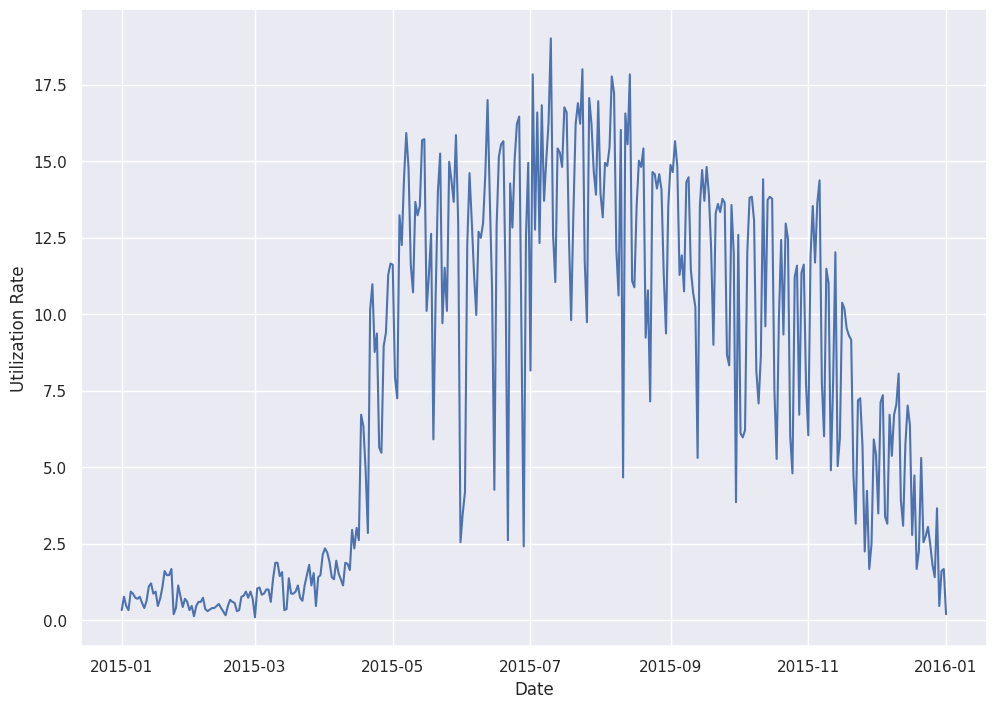

In [ ]:
# Get prepared data
df_utilization_rate_per_day = df_splitted_trips.copy()

# Get number of unique values grouped by date and time of day
df_utilization_rate_per_day = df_utilization_rate_per_day.groupby(['Date', 'Time of day (hour)']).nunique()

# Calculate utilization rate
df_utilization_rate_per_day['Utilization Rate'] = df_utilization_rate_per_day['bike_id']/amountOfBikes*100

# Calculate median for utilization rate per day
df_utilization_rate_per_day = df_utilization_rate_per_day.groupby('Date')['Utilization Rate'].median().reset_index()

# Plot median utilizaiton rate per day
sns.lineplot(data=df_utilization_rate_per_day, x='Date', y='Utilization Rate')

### Median of utilization rate per week

In [ ]:
# Get prepared data
df_utilization_rate_per_week = df_splitted_trips.copy()

# Insert column week
df_utilization_rate_per_week['Week'] = df_utilization_rate_per_week['start_time'].dt.isocalendar().week

# Get number of unique values grouped by week and time of day
df_utilization_rate_per_week = df_utilization_rate_per_week.groupby(['Date', 'Week', 'Time of day (hour)']).nunique()

# Calculate utilization rate
df_utilization_rate_per_week['Utilization Rate'] = df_utilization_rate_per_week['bike_id']/amountOfBikes*100

# Calculate median for utilization rate per day
df_utilization_rate_per_week = df_utilization_rate_per_week.groupby(['Week', 'Time of day (hour)'])['Utilization Rate'].median().reset_index()
df_utilization_rate_per_week = df_utilization_rate_per_week.groupby('Week')['Utilization Rate'].median().reset_index()

# Plot median utilizaiton rate per day
sns.lineplot(data=df_utilization_rate_per_week, x='Week', y='Utilization Rate')

NameError: name 'df_splitted_trips' is not defined

### Coverage

### Revenue

### Clustering